# Distributed Grid Search with MPI

This notebook demonstrates how to run grid search across multiple processes using MPI (Message Passing Interface). This approach enables:

- **Massive parameter space exploration** across multiple CPU/GPU cores/nodes
- **HPC cluster utilization** for large-scale hyperparameter optimization
- **Memory distribution** for handling large computational workloads

## 📋 Requirements

- **MPI implementation** (OpenMPI, MPICH, or cluster-specific)
- **JAX with distributed support** 
- **jax_grid_search** package
- **mpi4py** (if you are using mpirun or mpiexec)

## 🔧 Setup Instructions

### Install MPI (if not available):
```bash
# Ubuntu/Debian
sudo apt-get install -y libopenmpi-dev
# Most HPC clusters have MPI pre-installed
module load mpi
```

## Checking MPI Installation

First, ensure that MPI is correctly installed and accessible.

In [21]:
# Check if MPI is available
import subprocess


def check_mpi():
    try:
        result = subprocess.run(["mpirun", "--version"], capture_output=True, text=True, timeout=10)
        if result.returncode == 0:
            print("✅ MPI is available!")
            print(f"Version info: {result.stdout.split()[0:3]}")
            return True
        else:
            print("❌ MPI command failed")
            return False
    except FileNotFoundError:
        print("❌ MPI not found. Please install MPI first.")
        print("Try: sudo apt-get install mpich  (Ubuntu/Debian)")
        print("Or:  brew install mpich  (macOS)")
        return False
    except subprocess.TimeoutExpired:
        print("❌ MPI check timed out")
        return False


mpi_available = check_mpi()

✅ MPI is available!
Version info: ['mpirun', '(Open', 'MPI)']


In [22]:
import os

import jax.numpy as jnp
import matplotlib.pyplot as plt

from jax_grid_search import DistributedGridSearch

## Running Distributed Grid Search

The distributed script optimizes neural network hyperparameters across multiple processes:

- **15 learning rates** (log scale from 1e-4 to 1e-1)
- **8 batch sizes** (16, 32, 48, 64, 96, 128, 192, 256)
- **7 dropout rates** (0.0 to 0.6)
- **7 layer counts** (2 to 8 layers)
- **3 optimizers** (SGD, Adam, AdamW)

**Total combinations**: 15 × 8 × 7 × 7 × 3 = **17,640 evaluations**

In [23]:
# Clean up any previous results
import shutil

if os.path.exists("distributed_results"):
    shutil.rmtree("distributed_results")
    print("Cleaned up previous results")

# Show what the script will do
total_combinations = 15 * 8 * 7 * 7 * 3
processes = 4
script_path = "05-distributed-grid-search.py"

print("About to run distributed grid search:")
print(f"  Total combinations: {total_combinations:,}")
print(f"  Processes: {processes}")
print(f"  Combinations per process: ~{total_combinations // processes:,}")
print("  Estimated time: 30-60 seconds")
print(f"\nCommand: mpirun -n {processes} python {script_path}")

About to run distributed grid search:
  Total combinations: 17,640
  Processes: 4
  Combinations per process: ~4,410
  Estimated time: 30-60 seconds

Command: mpirun -n 4 python 05-distributed-grid-search.py


In [24]:
%%time
# Run the distributed grid search
# Note: This cell will take 30-60 seconds to complete
!mpirun -n 4 python 05-distributed-grid-search.py

/home/wassim/micromamba/envs/p11/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Distributed Grid Search Started
Total processes: 4
Total combinations: 17,640
Combinations per process: ~4,410
Process 1 will process 4410 combinations with batch size 128
Process 2 will process 4410 combinations with batch size 128
Process 0 will process 4410 combinations with batch size 128
Processing batches on device 0/4: 100%|██████████| 35/35 [00:07<00:00,  4.39it/s]
Distributed grid search completed in 8.2 seconds
Results saved to 'distributed_results/' directory
Ready for result analysis in notebook!
CPU times: user 304 ms, sys: 110 ms, total: 415 ms
Wall time: 13.7 s


##  Loading and Analyzing Results

Once the distributed grid search is complete, load and analyze the results that were conducted across multiple processes.

Each process saves its results to a shared directory. and named based on its rank (e.g., `results_batch_X_rank_0.pkl`, `results_batch_Xrank_1.pkl`, etc.).

In [25]:
# Load and stack results from all processes
print("📥 Loading distributed results...")

# Use DistributedGridSearch to aggregate results
results = DistributedGridSearch.stack_results("distributed_results")

if results is None:
    print("❌ No results found! Check if the distributed run completed successfully.")
else:
    print(f"✅ Successfully loaded {len(results['value']):,} evaluations")
    print(f"📁 Result keys: {list(results.keys())}")

    # Quick stats
    print("\n📈 Quick Statistics:")
    print(f"  Best objective value: {results['value'][0]:.6f}")
    print(f"  Worst objective value: {results['value'][-1]:.6f}")
    print(f"  Mean objective value: {jnp.mean(results['value']):.6f}")
    print(f"  Objective std: {jnp.std(results['value']):.6f}")

📥 Loading distributed results...
Loading from 0 to 140 (batch size 140)


Converting to arrays: 100%|██████████| 13/13 [00:02<00:00,  4.86it/s]


✅ Successfully loaded 17,640 evaluations
📁 Result keys: ['learning_rate', 'batch_size', 'dropout', 'num_layers', 'optimizer_type', 'batch_efficiency', 'complexity_penalty', 'dropout_penalty', 'lr_batch_interaction', 'noise_component', 'optimizer_penalty', 'predicted_accuracy', 'value']

📈 Quick Statistics:
  Best objective value: 0.387973
  Worst objective value: 4.844120
  Mean objective value: 2.501686
  Objective std: 1.000140


##  Best Hyperparameter Configurations

In [26]:
# Best configuration analysis
print("🥇 BEST HYPERPARAMETER CONFIGURATION:")
print("=" * 50)

best_idx = 0  # Results are sorted by default
optimizer_names = {0: "SGD", 1: "Adam", 2: "AdamW"}

print(f"Learning Rate:    {results['learning_rate'][best_idx]:.6f}")
print(f"Batch Size:       {int(results['batch_size'][best_idx])}")
print(f"Dropout Rate:     {results['dropout'][best_idx]:.3f}")
print(f"Number of Layers: {int(results['num_layers'][best_idx])}")

opt_type = int(results["optimizer_type"][best_idx])
print(f"Optimizer:        {optimizer_names.get(opt_type, f'Unknown({opt_type})')}")
print(f"\nObjective Value:  {results['value'][best_idx]:.6f}")
print(f"Predicted Accuracy: {results['predicted_accuracy'][best_idx]:.4f}")

# Component analysis for best result
print("\n🔍 OBJECTIVE COMPONENT BREAKDOWN:")
components = [
    ("LR-Batch Interaction", results["lr_batch_interaction"][best_idx]),
    ("Dropout Penalty", results["dropout_penalty"][best_idx]),
    ("Optimizer Penalty", results["optimizer_penalty"][best_idx]),
    ("Complexity Penalty", results["complexity_penalty"][best_idx]),
    ("Batch Efficiency", results["batch_efficiency"][best_idx]),
    ("Noise Component", results["noise_component"][best_idx]),
]

for comp_name, comp_value in components:
    print(f"  {comp_name:<20}: {comp_value:.6f}")

🥇 BEST HYPERPARAMETER CONFIGURATION:
Learning Rate:    0.100000
Batch Size:       256
Dropout Rate:     0.400
Number of Layers: 8
Optimizer:        AdamW

Objective Value:  0.387973
Predicted Accuracy: 0.9112

🔍 OBJECTIVE COMPONENT BREAKDOWN:
  LR-Batch Interaction: 0.397940
  Dropout Penalty     : 0.000000
  Optimizer Penalty   : 0.000000
  Complexity Penalty  : 0.000000
  Batch Efficiency    : 0.000000
  Noise Component     : -0.009967


##  Visualization and Analysis

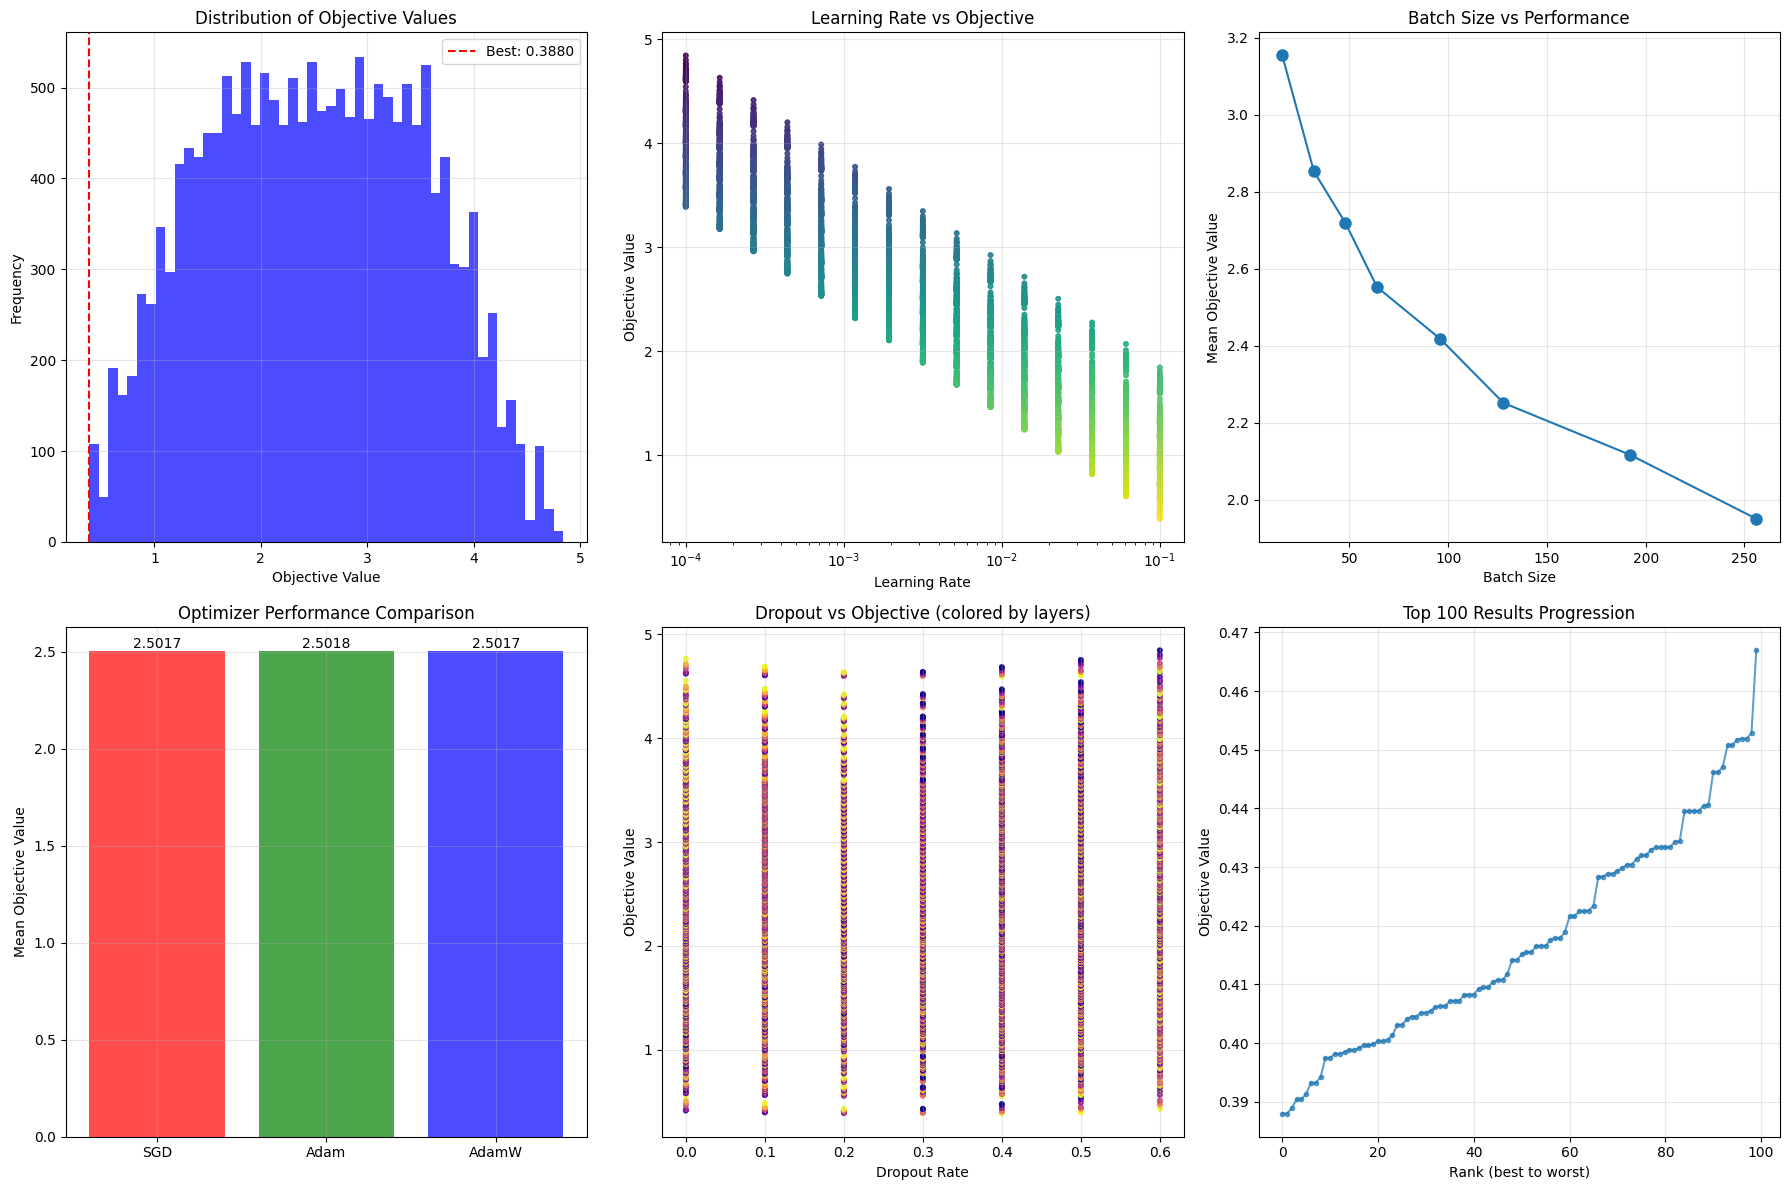

In [27]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Objective value distribution
axes[0, 0].hist(results["value"], bins=50, alpha=0.7, color="blue")
axes[0, 0].axvline(results["value"][0], color="red", linestyle="--", label=f"Best: {results['value'][0]:.4f}")
axes[0, 0].set_xlabel("Objective Value")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_title("Distribution of Objective Values")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Learning rate vs objective
axes[0, 1].scatter(results["learning_rate"], results["value"], alpha=0.5, s=10, c=results["predicted_accuracy"], cmap="viridis")
axes[0, 1].set_xlabel("Learning Rate")
axes[0, 1].set_ylabel("Objective Value")
axes[0, 1].set_title("Learning Rate vs Objective")
axes[0, 1].set_xscale("log")
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Batch size analysis
batch_sizes = jnp.unique(results["batch_size"])
batch_means = [jnp.mean(results["value"][results["batch_size"] == bs]) for bs in batch_sizes]
axes[0, 2].plot(batch_sizes, batch_means, "o-", markersize=8)
axes[0, 2].set_xlabel("Batch Size")
axes[0, 2].set_ylabel("Mean Objective Value")
axes[0, 2].set_title("Batch Size vs Performance")
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Optimizer comparison
optimizer_names = ["SGD", "Adam", "AdamW"]
opt_means = [jnp.mean(results["value"][results["optimizer_type"] == i]) for i in range(3)]
bars = axes[1, 0].bar(optimizer_names, opt_means, color=["red", "green", "blue"], alpha=0.7)
axes[1, 0].set_ylabel("Mean Objective Value")
axes[1, 0].set_title("Optimizer Performance Comparison")
axes[1, 0].grid(True, alpha=0.3)

# Add value labels on bars
for bar, mean_val in zip(bars, opt_means):
    axes[1, 0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.001, f"{mean_val:.4f}", ha="center", va="bottom")

# Plot 5: Dropout rate analysis
axes[1, 1].scatter(results["dropout"], results["value"], alpha=0.5, s=10, c=results["num_layers"], cmap="plasma")
axes[1, 1].set_xlabel("Dropout Rate")
axes[1, 1].set_ylabel("Objective Value")
axes[1, 1].set_title("Dropout vs Objective (colored by layers)")
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Best results over "time" (rank)
axes[1, 2].plot(results["value"][:100], "o-", markersize=3, alpha=0.7)
axes[1, 2].set_xlabel("Rank (best to worst)")
axes[1, 2].set_ylabel("Objective Value")
axes[1, 2].set_title("Top 100 Results Progression")
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Cleanup

In [29]:
# Optional: Clean up result files

if os.path.exists("distributed_results"):
    shutil.rmtree("distributed_results")
    print("🧹 Cleaned up result files")